# Check IceBridge for test period (2011-2013)

In [10]:
import numpy as np
import re
import datetime

In [6]:
from src.utils import quickplot

In [7]:
import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

In [8]:
ifile = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/unified_processed/IceBridge-V2_summaries_SIT_monthlymean.npy'

In [9]:
sitm = np.load(ifile)

In [11]:
def load_IceBridge(campaign='V2', dt_lim_min=None, dt_lim_max=None):
    '''
    Parameters:
    -----------
    
        campaign     :    string, 'V2' or 'QL', to load one campaign or the other
        dt_lim_min       :    datetime object, if given, only days after dt_min will be returned
        dt_lim_max       :    datetime object, if given, only days before dt_min will be returned
    '''
    
    idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/unified-sea-ice-thickness-cdr-1947-2017/'

    if campaign == 'QL':
        ifile = 'IceBridge-QL.summaries.2012.2015.V20160310.txt'
    elif campaign == 'V2':
        ifile = 'IceBridge-V2.summaries.2009.2013.V20160310.txt'


    with open(f'{idir}{ifile}','r') as f:  # read .txt.
        lines = f.readlines()

    header = [item for item in re.split(' +', lines[0])][1:-1] + ['First']   # get header

    # get data
    data = np.genfromtxt(f'{idir}{ifile}', delimiter='\t', dtype='U255', skip_header=1, autostrip=True)
    types_data = ['U12','U12', 'int', 'int']+ ['float']*3 +['int']+ ['float']*6+ ['int', 'int']+ ['float']*12

    # array with all the lines
    arr = []
    for dt in data:
        arr += [item for item in re.split(' +', dt)]

    nlines = data.shape[0]
    bb = np.array(arr).reshape(nlines,28)

    # create dictionary from the array
    dico = {}

    for idx, (var, typecol) in enumerate(zip(header, types_data)):
        # format data
        if typecol == 'U12':
            typec = 'U12'
        elif typecol == 'float':
            typec = np.float64
        elif typecol == 'int':
            typec = np.int64

        dico[f'{var}'] = np.asarray(bb[:,idx], dtype=typec)

    # get a decent time variable
    dt = np.array([datetime.datetime(int(yr),1,1)+ datetime.timedelta(days=ydy) for yr, ydy in zip(dico['Year'], dico['Yday'])])
    dt_min = np.array([datetime.datetime(int(yr),1,1)+ datetime.timedelta(days=ydy) for yr, ydy in zip(dico['Year'], dico['MinDay'])])
    dt_max = np.array([datetime.datetime(int(yr),1,1)+ datetime.timedelta(days=ydy) for yr, ydy in zip(dico['Year'], dico['MaxDay'])])

    if dt_lim_min is None and dt_lim_max is None:  # return all dates
        return dico['Lon'], dico['Lat'], dico['Avg_thkns'], dico['Avg_thunc'], dico['Avg_snow'], dt_min, dt_max
    
    else:  # exclude dates outside of [dt_min, dt_max]
        idx_min = 0
        idx_max = len(dico['Lon'])
        if dt_min is not None:  # first valid item
            idx_min = np.where(dt>dt_lim_min)[0][0]
        if dt_max is not None:  # last valid item
            idx_max = np.where(dt<dt_lim_max)[0][-1]
        
        return dico['Lon'][idx_min:idx_max], dico['Lat'][idx_min:idx_max], \
                dico['Avg_thkns'][idx_min:idx_max], dico['Avg_thunc'][idx_min:idx_max], \
                dico['Avg_snow'][idx_min:idx_max], dt_min[idx_min:idx_max], dt_max[idx_min:idx_max]
    
    
    


In [12]:
dt_min = datetime.datetime(2011,1,1)
dt_max = datetime.datetime(2013,12,31)

In [13]:
lon, lat, sit, situ, sd, chrono_min, chrono_max = load_IceBridge(campaign='QL', dt_lim_min=datetime.datetime(2011,1,1), dt_lim_max=dt_max)

In [14]:
# just for plot
dt_sec = np.array([(t0-datetime.datetime(1970,1,1)).total_seconds() for t0 in chrono_min])

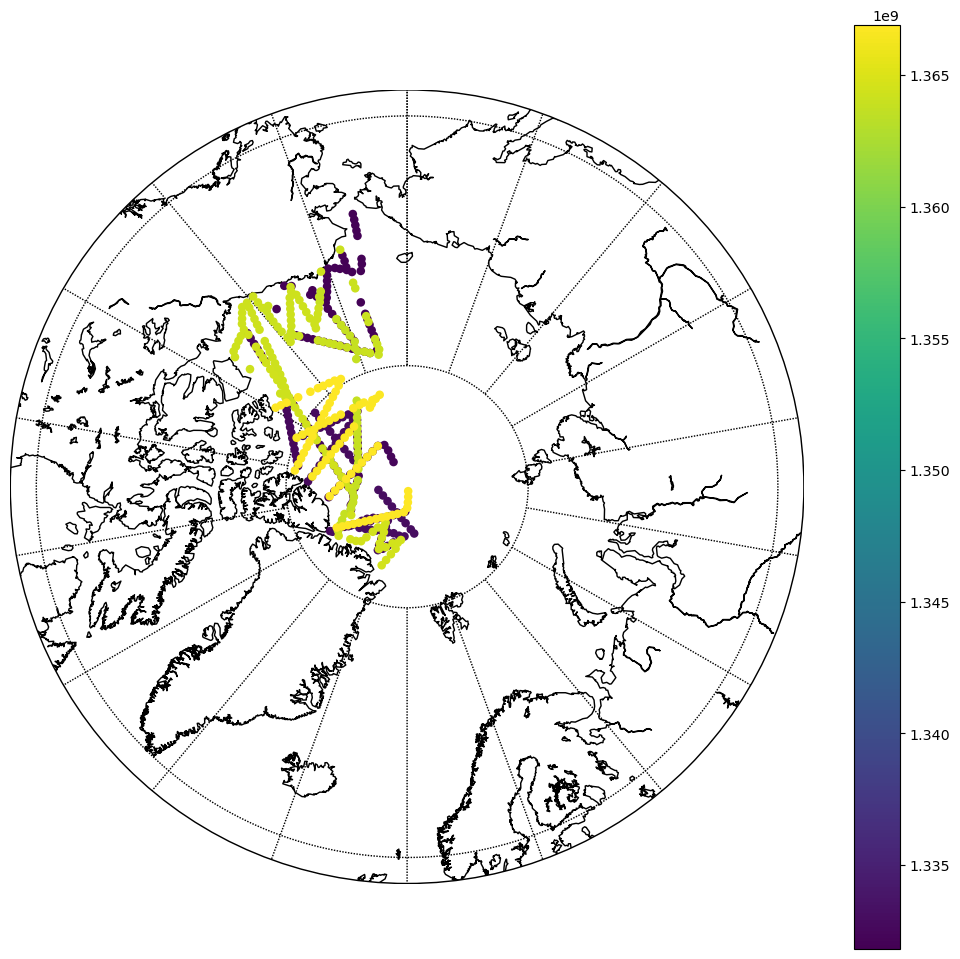

In [15]:
quickplot.basemap(lon, lat, var=dt_sec, label='Datetime')

In [16]:
# -----------------------------------
#          Functions
# -----------------------------------


def get_closest_tindex_period(chrono, d1, d2, max_days=1):
    '''Returns indexes in TOPAZ between 2 datetime objects
    
    Parameters:
    -----------
        chrono   :       chrono from TOPAZ4
        d1       :       datetime object, first date in date
        d2       :       datetime object, lastest date in date
        max_days :       int, maximum number of days between model and observation (to be considered valid)
    '''
    # identify index to plot
    chrono_dt = np.array([datetime.datetime.combine(dt.date(),
                                              datetime.time(0)) for dt in chrono.date])
        
    d1_min = np.array([abs(d1 - dt) for dt in chrono_dt])
    idx_min = np.argmin(d1_min)
    
    d2_min = np.array([abs(d2 - dt) for dt in chrono_dt])
    idx_max =  np.argmin(d2_min)
    
#     import pdb; pdb.set_trace()
    if d1_min[idx_min] > datetime.timedelta(days=max_days) and \
        d2_min[idx_max] > datetime.timedelta(days=max_days):
        print('No valid time')
        return np.array([])
    
    elif d1_min[idx_min] > datetime.timedelta(days=max_days):
        print('Only datetime max valid')
        return np.array([idx_max])

    elif d2_min[idx_max] > datetime.timedelta(days=max_days):
        print('Only datetime min valid')
        return np.array([idx_min])
    
    
    return np.arange(idx_min, idx_max+1)


def get_closest_mean_std(lat, lon, tmin, tmax, sit_tp, chrono):
    '''
    Returns TOPAZ SIT (mean and std) for closest point in space and over time interval
    for one given (lat, lon) point (from ICESAT campaigns)
    
    Parameters:
    -----------
        lat           :    latitude of one given point
        lon           :    longitude of one given point
        tmin          :    datetime object, first date of one given point
        tmax          :    datetime object, last date of one given point
        sit_tp        :    xarray.DataArray, Sea Ice Thickness ML-corrected from TOPAZ4
        chrono        :    panda.DataFrame, dates associated to sit_tp
    
    '''

    # for oone given (lat,lon) point
    # get time index between Time min and Time max
    tloc = get_closest_tindex_period(chrono, tmin, tmax)
    
    # localise the closest TOPAZ points for the (lat, lon) point
    # from https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(sit_tp.latitude-lat)
    abslon = np.abs(sit_tp.longitude-lon)
    c = np.maximum(abslon, abslat)
    closest = np.where(c == np.min(c))
    
    if closest[0].size > 1:  # rare case where one (lat,lon) point is at equal distance of 2 grid points
        # then we just pick the first one
        yloc = closest[0][0]
        xloc = closest[1][0]
    else:
        ([yloc], [xloc]) = closest
    
    point_ds = sit_tp.isel(time=tloc, x=xloc, y=yloc)
    
    # print(f'TOPAZ4 global corrected with RF, SIT: {point_ds.mean().data}')
    # print(f'ICESAT , SIT: {dico_ice["Avg_thkns"][index][pi]}')
    
    return np.array([point_ds.mean(), point_ds.std()])  # return mean and std
#     return point_ds  # return all points


In [17]:
from src.data_preparation import load_data
from src.modelling import sit_corrected

In [18]:
# ---------------------------------
#       Import all predictions
# ---------------------------------

### LSTM model
irootdir= f'{rootdir}'
ipath = 'Leo/results/lstm_230919-170402/'
ml_name ='LSTM'

ifile = f'{irootdir}{ipath}'
sitm = sit_corrected.SITCorrected(ifile, name=ml_name, verbose=1)



# ------------------------------------------------
##            Reconstruct SIT values 
# ------------------------------------------------

print('\nReconstructing SIT...')

sitm.reconstruct_sit()

Config file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_230919-170402/config_default_2023_fast.yaml
Folder: Leo/results/lstm_230919-170402/figures/sit_reconstruct/

Initialisation SIT from LSTM
ML prediction .nc file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_230919-170402/ml/ypred_LSTM_2011_2022.nc

Reconstructing SIT...


In [19]:
# SIT already reconstructed

# irootdir = f'{rootdir}'
# ipath = 'Leo/results/lstm_230904-170733/ml/sit_gLSTM3_bk_2010_2022_01.nc'

# filename = f'{irootdir}{ipath}'

# sit_ml, chrono = load_data.load_nc(filename, 'sit_ml', X_only=True)

# sit_bl, chrono =  0, 0  # to load!!

In [20]:
# ------------------------------------------------
# ---------------- Colocalisation ----------------
# ------------------------------------------------

In [21]:
n_obs = sit.size

In [22]:
# Get TOPAZ data for all ICESAT points
tp_mean_std = np.zeros((n_obs,2))
tp_bl_mean_std = np.zeros((n_obs,2))

In [23]:
for ni in range(n_obs):
    tp_mean_std[ni] = get_closest_mean_std(lat[ni], lon[ni], chrono_min[ni], chrono_max[ni], sitm.sit, sitm.chrono)
    tp_bl_mean_std[ni] = get_closest_mean_std(lat[ni], lon[ni], chrono_min[ni], chrono_max[ni], sitm.sit_bl, sitm.chrono)    

In [24]:
sit_mlc = tp_mean_std[:,0]

In [25]:
sit_blc = tp_bl_mean_std[:,0]

In [26]:
import matplotlib.pyplot as plt

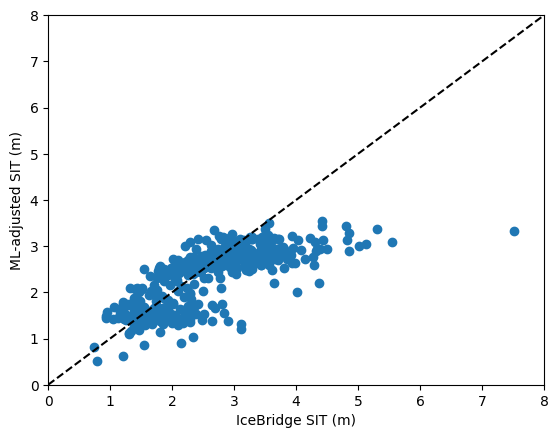

In [35]:
plt.scatter(sit, sit_mlc)
plt.xlim([0,8])
plt.ylim([0,8])
plt.xlabel('IceBridge SIT (m)')
plt.ylabel('ML-adjusted SIT (m)')
plt.plot([0,8], [0,8], 'k--')

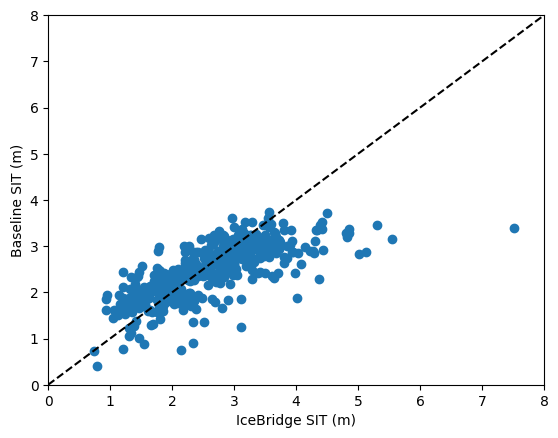

In [34]:
plt.scatter(sit, sit_blc)
plt.xlim([0,8])
plt.ylim([0,8])
plt.xlabel('IceBridge SIT (m)')
plt.ylabel('Baseline SIT (m)')
plt.plot([0,8], [0,8], 'k--')

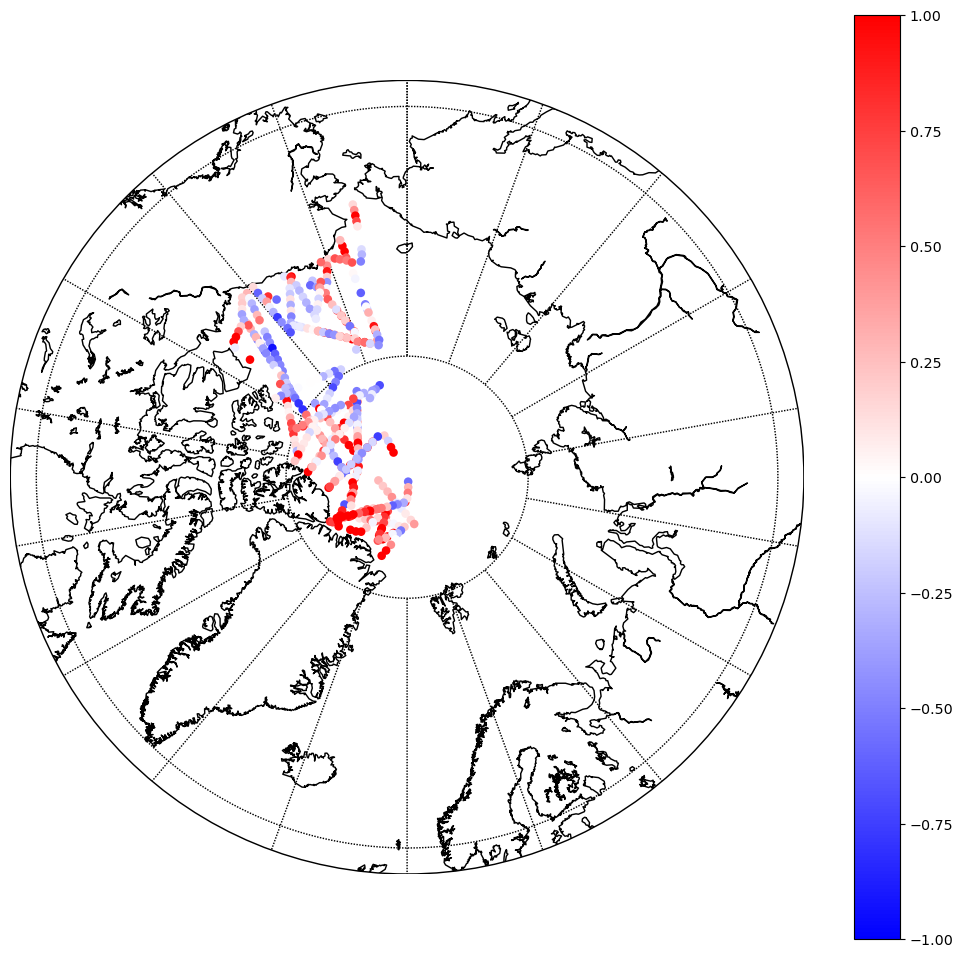

In [29]:
quickplot.basemap(lon, lat, var=sit-sit_mlc, label='Bias SIT (m)', vmin=-1, vmax=1, cmap=plt.get_cmap('bwr'))

In [30]:
from mpl_toolkits.basemap import Basemap

from src.utils import modif_plot
from src.utils import save_name
from src.utils import npstere_zoom

/tmp/ipykernel_187109/2338999821.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])
/tmp/ipykernel_187109/2338999821.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-1', '', '-0.5','','0','','0.5','','1'])


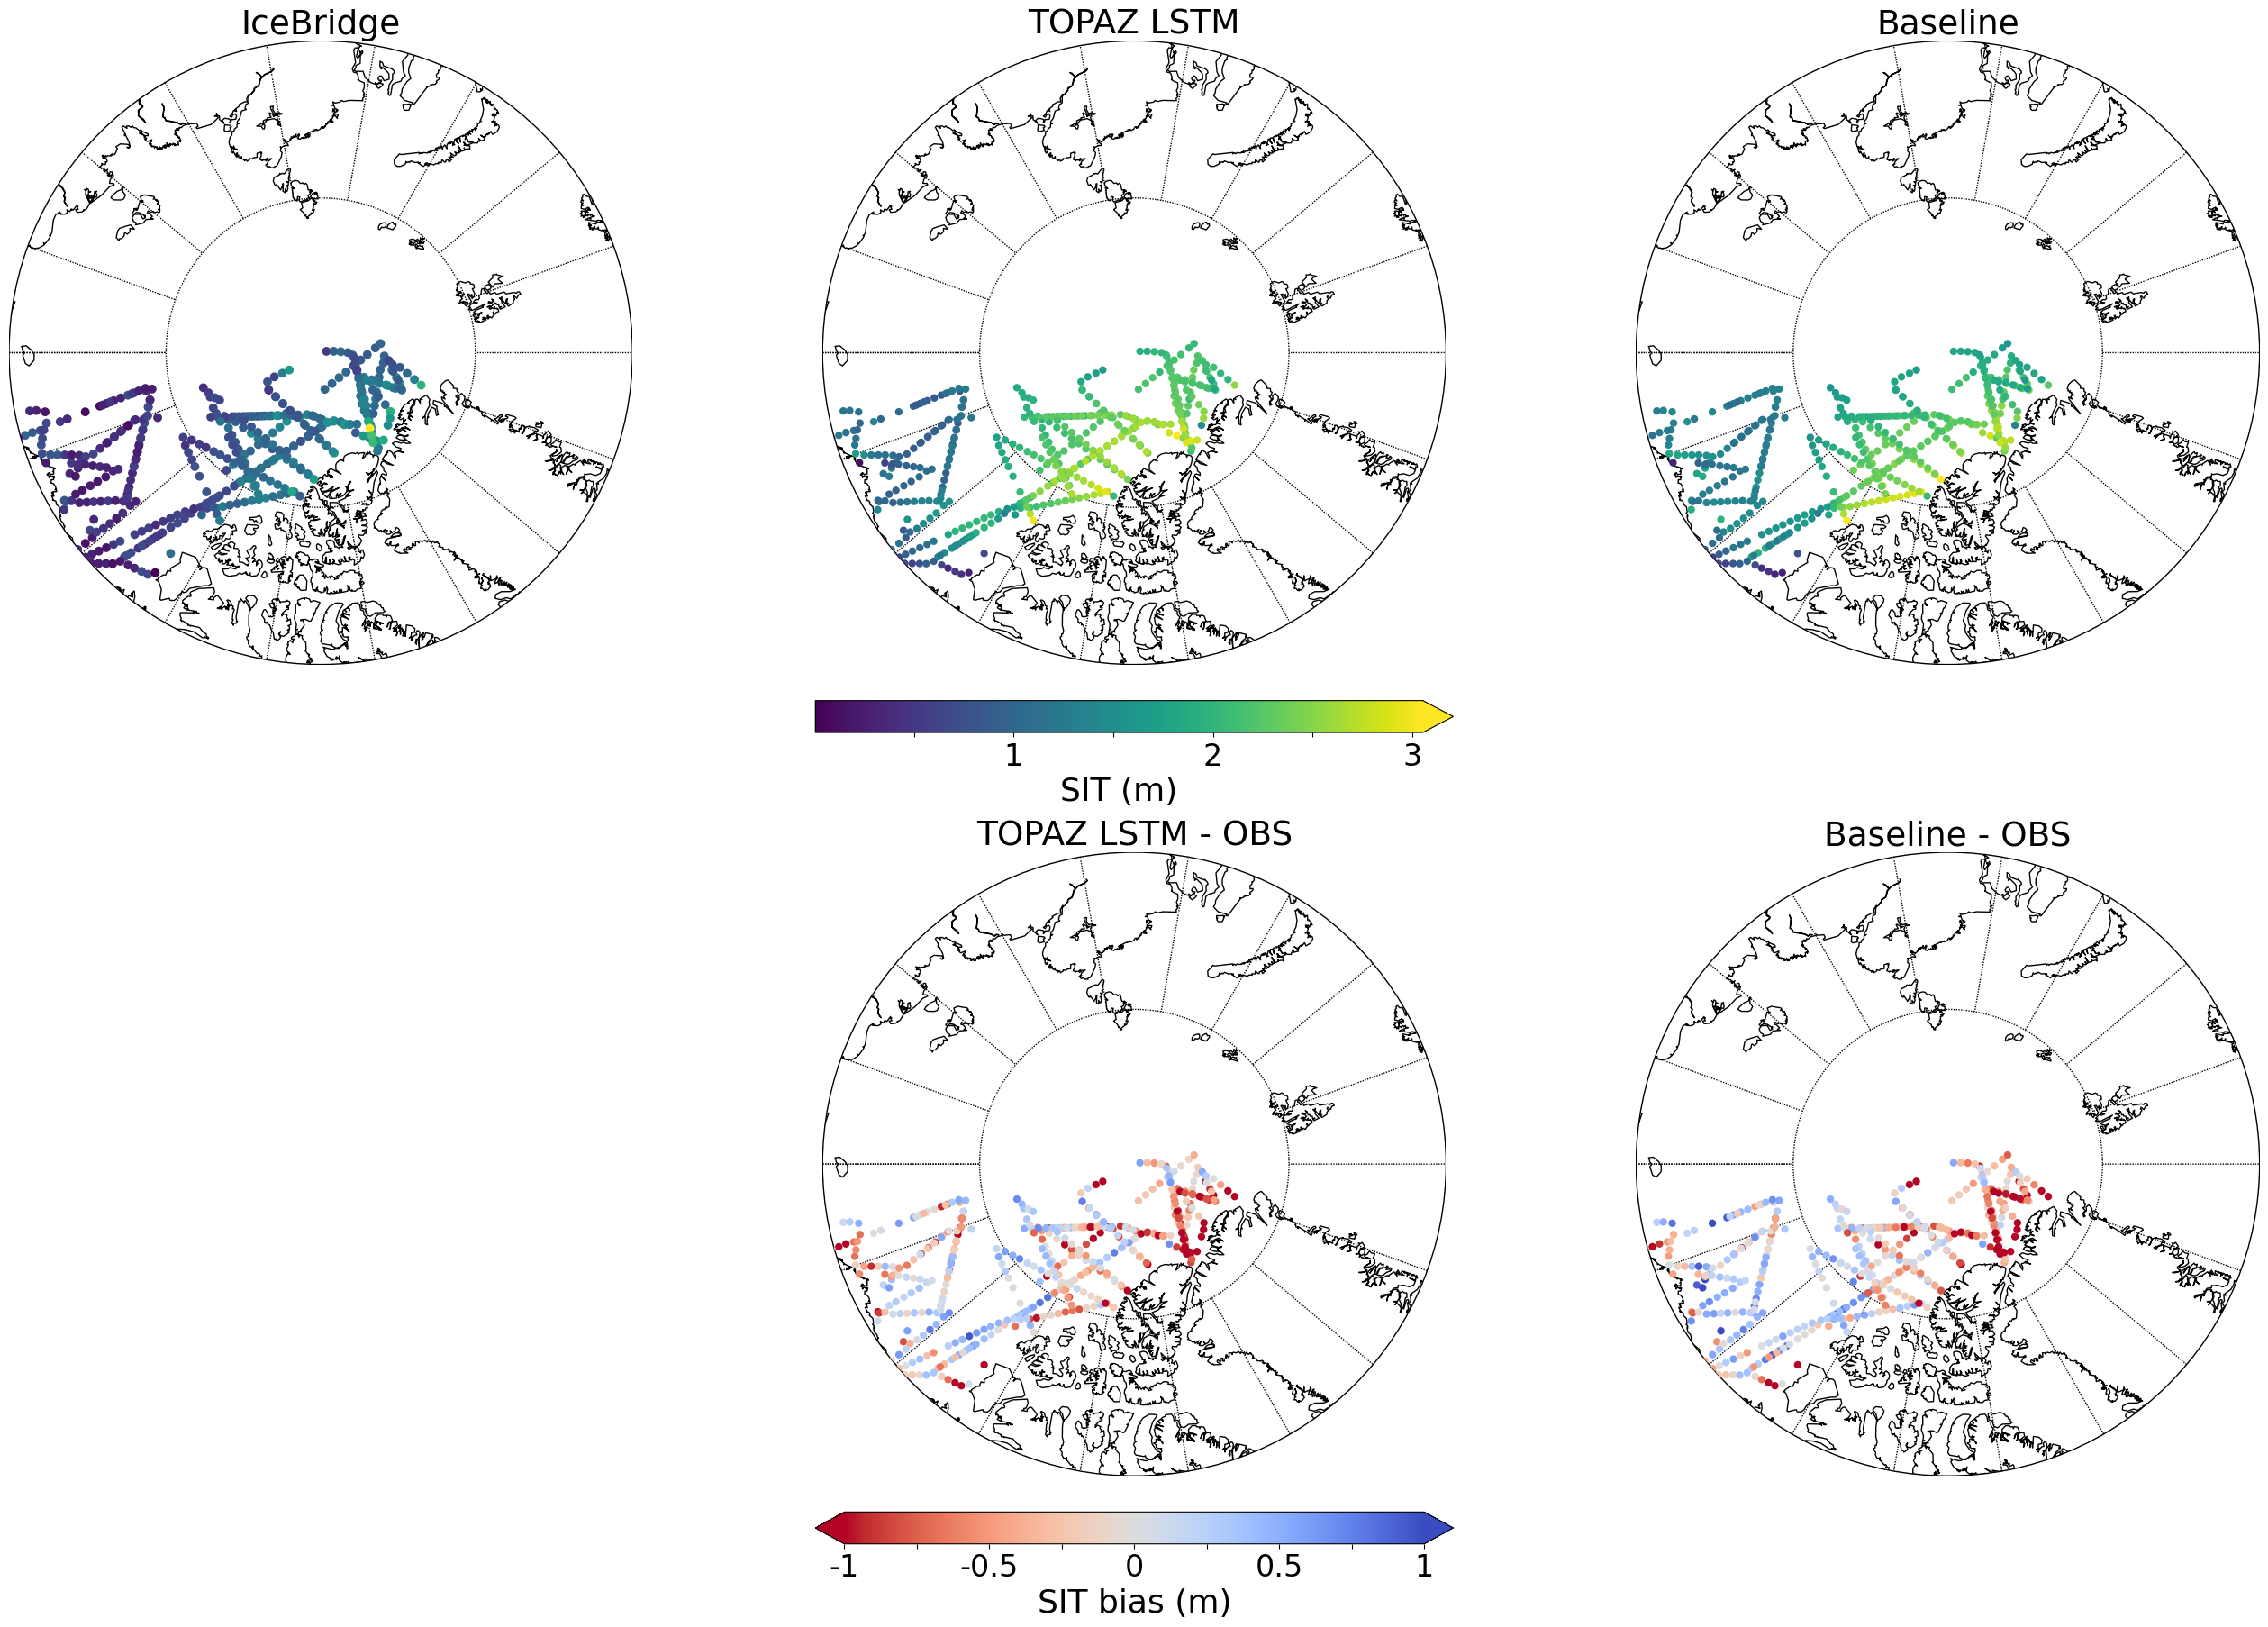

In [31]:
draw_sit_baseline(lat, lon, sit, sit_mlc, sit_blc)

/tmp/ipykernel_187109/3538003145.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])
/tmp/ipykernel_187109/3538003145.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-1', '', '-0.5','','0','','0.5','','1'])


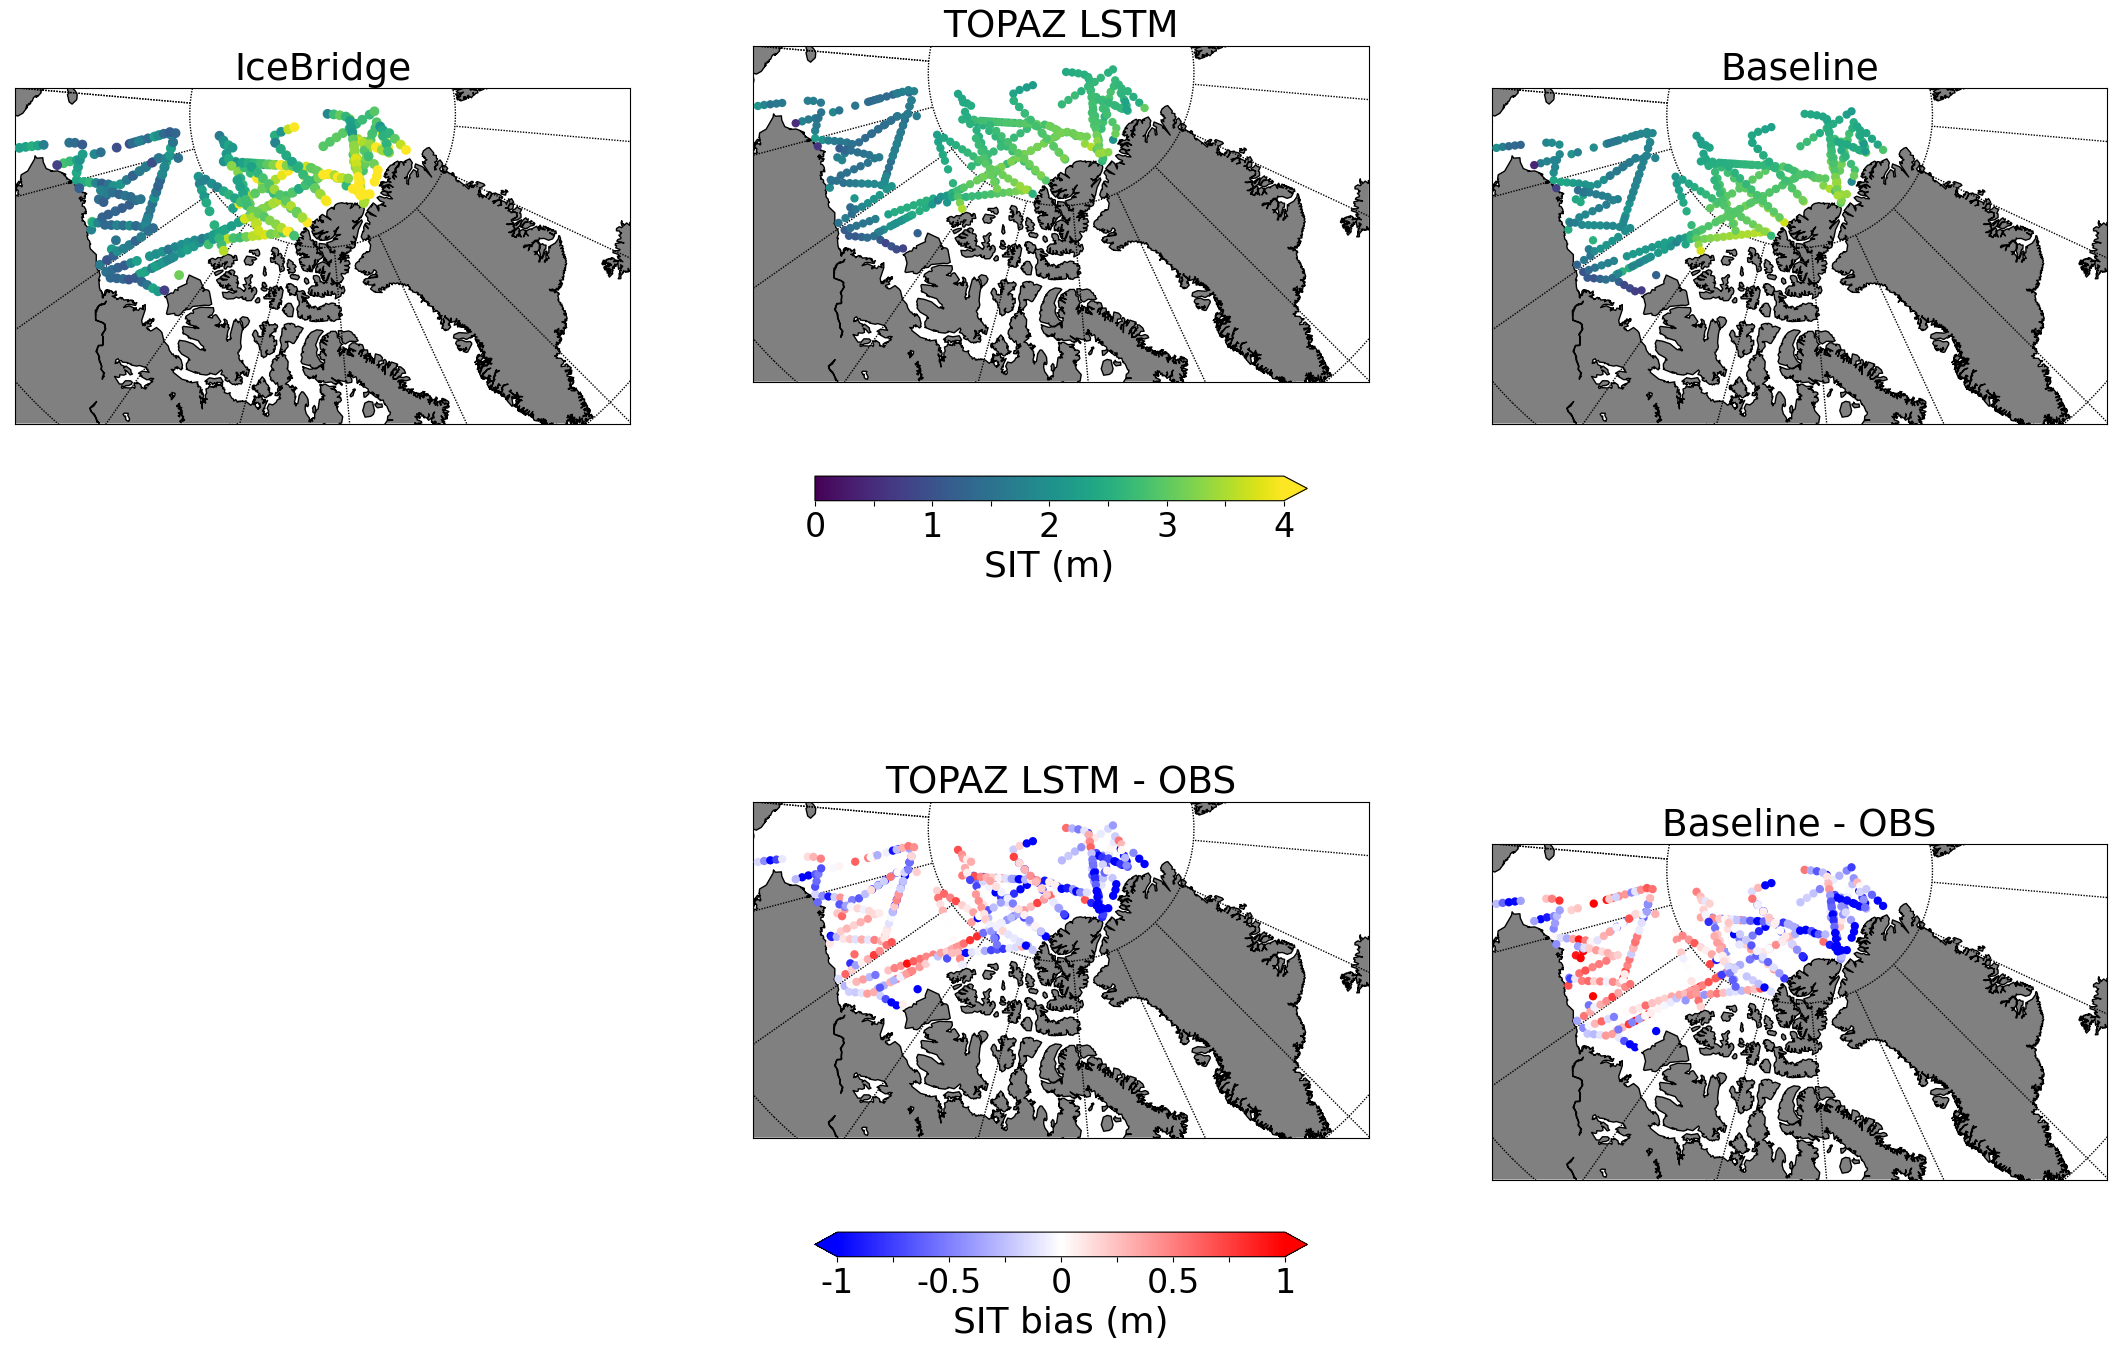

In [32]:
draw_sit_baseline_zoom(lat, lon, sit, sit_mlc, sit_blc)

In [33]:
compute_errors(sit_mlc, sit_blc, sit)



ML-adjusted - ULS
bias  :      -0.250
rmse  :      0.665
mean corr:   0.744     p value:    0.000000


Baseline - ULS
bias  :      -0.151
rmse  :      0.634
mean corr:   0.748     p value:    0.000000


In [4]:
from scipy import stats

In [1]:
def draw_sit_baseline(lats, lons, sit_obs, sit_tp, sit_bl, suptitle='', odir='', ofile='', savefig=False, showfig=True, **kwargs):
    '''
    Parameters:
    -----------
    
        sit_obs      : Sea Ice Thickness from ICESAT (or other)
        sit_tp       : Sea Ice Thickness from ToPaz LSTM
        sit_bl       : Sea Ice Thickness from Baseline
    
    '''
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(9*3, 9*2), constrained_layout=True)
    
    # ---- SIT ----
    
    m = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[0][0])
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, s=50, **kwargs)
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[0][0].set_title('IceBridge')
    
    
    m2 = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[0][1])
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m2.scatter(lons, lats, c=sit_tp, lw=0, latlon=True, zorder=10, **kwargs)
    axes[0][1].set_title('TOPAZ LSTM')
    
    m3 = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[0][2])
    m3.drawcoastlines()
    m3.drawparallels(np.arange(-80.,81.,20.))
    m3.drawmeridians(np.arange(-180.,181.,20.))
    cs3 = m3.scatter(lons, lats, c=sit_bl, lw=0, latlon=True, zorder=10, **kwargs)
    axes[0][2].set_title('Baseline')
    
    cbar = fig.colorbar(cs2, ax=axes[0][1], shrink=.8, location="bottom", extend='max', label='SIT (m)')
#     cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])
    cbar.ax.set_xticks([0,1,2,3,4])
    
    # ---- Bias ----
    
    axes[1][0].set_visible(False)
    
    cmap = plt.get_cmap('coolwarm_r')
    vmin=-1
    vmax=1
    
    m2 = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[1][1])
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m2.scatter(lons, lats, c=sit_tp-sit_obs, lw=0, latlon=True, zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    axes[1][1].set_title('TOPAZ LSTM - OBS')
    
    m3 = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[1][2])
    m3.drawcoastlines()
    m3.drawparallels(np.arange(-80.,81.,20.))
    m3.drawmeridians(np.arange(-180.,181.,20.))
    cs3 = m3.scatter(lons, lats, c=sit_bl-sit_obs, lw=0, latlon=True, zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    axes[1][2].set_title('Baseline - OBS')
    
    
    
    cbar = fig.colorbar(cs2, ax=axes[1][1], shrink=0.8, location="bottom", extend='both', label='SIT bias (m)')
#     cbar.ax.set_xticklabels(['-1', '', '-0.5','','0','','0.5','','1'])
    cbar.ax.set_xticks([-1,-.5,0,.5,1])
    
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()


In [2]:
def draw_sit_baseline_zoom(lats, lons, sit_obs, sit_tp, sit_bl, suptitle='', odir='', ofile='', savefig=False, showfig=True, **kwargs):
    '''
    Parameters:
    -----------
    
        sit_obs      : Sea Ice Thickness from ICESAT (or other)
        sit_tp       : Sea Ice Thickness from ToPaz LSTM
        sit_bl       : Sea Ice Thickness from Baseline
    
    '''
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(9*3, 9*2)) # , constrained_layout=True)
    
    # ---- SIT ----
    
#     m = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[0][0])
    m00 = npstere_zoom.mzoom_subplot(ax=axes[0][0], lon_w=-180, lon_e=10, lat_s=67, lat_n=90)
    m00.drawcoastlines()
    m00.drawparallels(np.arange(-80.,81.,20.))
    m00.drawmeridians(np.arange(-180.,181.,20.))
    m00.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, s=50, vmin=0, vmax=4, **kwargs)
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[0][0].set_title('IceBridge')
    
    
#     m1 = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[0][1])
    m01 = npstere_zoom.mzoom_subplot(ax=axes[0][1], lon_w=-180, lon_e=10, lat_s=67, lat_n=90)
    m01.drawcoastlines()
    m01.drawparallels(np.arange(-80.,81.,20.))
    m01.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m01.scatter(lons, lats, c=sit_tp, lw=0, latlon=True, zorder=10,  vmin=0, vmax=4, **kwargs)
    axes[0][1].set_title('TOPAZ LSTM')
    
#     m02 = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[0][2])
    m02 = npstere_zoom.mzoom_subplot(ax=axes[0][2], lon_w=-180, lon_e=10, lat_s=67, lat_n=90)
    m02.drawcoastlines()
    m02.drawparallels(np.arange(-80.,81.,20.))
    m02.drawmeridians(np.arange(-180.,181.,20.))
    cs3 = m02.scatter(lons, lats, c=sit_bl, lw=0, latlon=True, zorder=10,  vmin=0, vmax=4, **kwargs)
    axes[0][2].set_title('Baseline')
    
    cbar = fig.colorbar(cs2, ax=axes[0][1], shrink=.8, location="bottom", extend='max', label='SIT (m)')
    cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])
    
    # ---- Bias ----
    
    axes[1][0].set_visible(False)
    
    cmap = plt.get_cmap('bwr')
    vmin=-1
    vmax=1
    
#     m1 = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[1][1])
    m11 = npstere_zoom.mzoom_subplot(ax=axes[1][1], lon_w=-180, lon_e=10, lat_s=67, lat_n=90)
    m11.drawcoastlines()
    m11.drawparallels(np.arange(-80.,81.,20.))
    m11.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m11.scatter(lons, lats, c=sit_tp-sit_obs, lw=0, latlon=True, zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    axes[1][1].set_title('TOPAZ LSTM - OBS')
    
#     m02 = Basemap(projection='npstere', boundinglat=70, lon_0=-90, resolution='l', round=True, ax=axes[1][2])
    m12 = npstere_zoom.mzoom_subplot(ax=axes[1][2], lon_w=-180, lon_e=10, lat_s=67, lat_n=90)
    m12.drawcoastlines()
    m12.drawparallels(np.arange(-80.,81.,20.))
    m12.drawmeridians(np.arange(-180.,181.,20.))
    cs3 = m12.scatter(lons, lats, c=sit_bl-sit_obs, lw=0, latlon=True, zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    axes[1][2].set_title('Baseline - OBS')
    
    
    
    cbar = fig.colorbar(cs2, ax=axes[1][1], shrink=0.8, location="bottom", extend='both', label='SIT bias (m)')
    cbar.ax.set_xticklabels(['-1', '', '-0.5','','0','','0.5','','1'])
    
    for mm in [m00, m01, m02, m11, m12]:
        mm.fillcontinents(color='grey')
    
    
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()


In [3]:
def compute_errors(sit_ml_loc, sit_bl_loc, sit, print_latex=False):
    '''Compute Bias/RMSE/Corr on average
    '''


    # remove nan
    tp_ml = sit_ml_loc[~np.isnan(sit)]  # topaz
    ref = sit[~np.isnan(sit)]  # reference = obs
    tp_bl = sit_bl_loc[~np.isnan(sit)]  # topaz
    
    c_val_ml, p_val_ml = stats.pearsonr(tp_ml, ref)  # returns correlation value, p value
    rmse_ml = np.sqrt((np.square(tp_ml-ref)).mean())
    bias_ml = (tp_ml - ref).mean()
    
    c_val_bl, p_val_bl = stats.pearsonr(tp_bl, ref)  # returns correlation value, p value
    rmse_bl = np.sqrt((np.square(tp_bl-ref)).mean())
    bias_bl = (tp_bl - ref).mean()

    print('\n\nML-adjusted - ULS')
    print(f'bias  :      {bias_ml:.03f}')
    print(f'rmse  :      {rmse_ml:.03f}')
    print(f'mean corr:   {c_val_ml:.03f}     p value:    {p_val_ml:.06f}')

    
    print('\n\nBaseline - ULS')
    print(f'bias  :      {bias_bl:.03f}')
    print(f'rmse  :      {rmse_bl:.03f}')
    print(f'mean corr:   {c_val_bl:.03f}     p value:    {p_val_bl:.06f}')    
    
    if print_latex:
        print('\nLatex table:')
        print(f'{bias_ml:.03f} ({bias_bl:.03f}) & {rmse_ml:.03f} ({rmse_bl:.03f}) & {c_val_ml:.03f} ({c_val_bl:.03f})\\')

# --------------------------------------------------------------------------------------------------

In [45]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

In [169]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

In [49]:
m2.bluemarble??

/tmp/ipykernel_67500/1376101206.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm1 = m2.pcolormesh(mlons, mlats, sitm.sit.isel(time=0).to_numpy(), vmin=0, vmax=4, cmap=cmap)


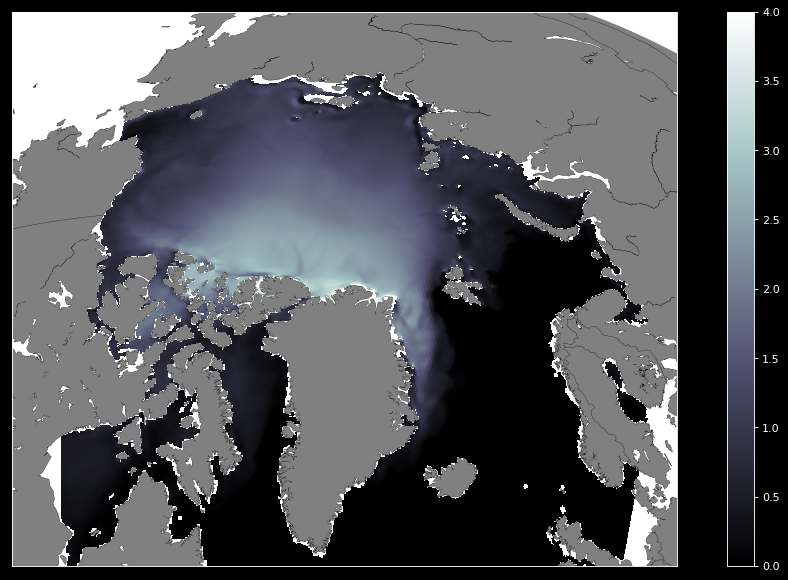

In [155]:
fig = plt.figure(figsize=(16, 9), dpi=80, facecolor='k')

cmap = plt.get_cmap('bone')

# set up orthographic m2 projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
# m2 = Basem2(projection='ortho',lat_0=50,lon_0=-10,resolution='l')

m2 = Basemap(projection = 'ortho', lon_0 = -40, lat_0 = 50,
            llcrnrx=-3000000, llcrnry=1000000, urcrnrx=3000000, urcrnry=6000000, 
            resolution = 'l')

# m2.bluemarble(scale=.4)


# draw coastlines, country boundaries, fill continents.
m2.drawcoastlines(linewidth=0.25)
m2.drawcountries(linewidth=0.25)

m2.fillcontinents(color='grey')
# draw the edge of the m2 projection region (the projection limb)
# m2.drawm2boundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
# m2.drawmeridians(np.arange(0,360,30), color='w')
# m2.drawparallels(np.arange(-90,90,30), color='w')

# m2.shadedrelief()

# m2.scatter(lat, lon, sit, latlon=True)
mlons, mlats = m2(sitm.sit.longitude.to_numpy(), sitm.sit.latitude.to_numpy())
cm1 = m2.pcolormesh(mlons, mlats, sitm.sit.isel(time=0).to_numpy(), vmin=0, vmax=4, cmap=cmap)

cbar = plt.colorbar(cm1)  # , fontsize=18)
# cbar.ax.tick_params(color='w') 
# cbar.ax.labelcolor(color='w') 


plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


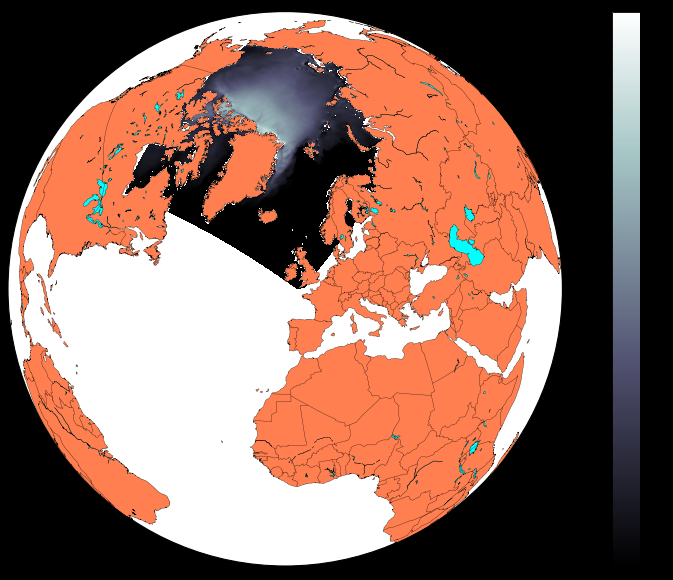

In [61]:
fig = plt.figure(figsize=(16, 9), dpi=80, facecolor='k')

cmap = plt.get_cmap('bone')

# set up orthographic m2 projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
m2 = Basemap(projection='ortho',lat_0=50,lon_0=-10,resolution='l')


m2.bluemarble(scale=.4)


# draw coastlines, country boundaries, fill continents.
m2.drawcoastlines(linewidth=0.25)
m2.drawcountries(linewidth=0.25)

m2.fillcontinents(color='coral',lake_color='aqua')
# draw the edge of the m2 projection region (the projection limb)
# m2.drawm2boundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
# m2.drawmeridians(np.arange(0,360,30), color='w')
# m2.drawparallels(np.arange(-90,90,30), color='w')

# m2.shadedrelief()

# m2.scatter(lat, lon, sit, latlon=True)
mlons, mlats = m2(sitm.sit.longitude.to_numpy(), sitm.sit.latitude.to_numpy())
cm1 = m2.pcolormesh(mlons, mlats, sitm.sit.isel(time=0).to_numpy(), vmin=0, vmax=4, cmap=cmap)

cbar = plt.colorbar(cm1)  # , fontsize=18)
# cbar.ax.tick_params(color='w') 
# cbar.ax.labelcolor(color='w') 


plt.show()

In [ ]:
mm = mzoom()

mm.bluemarble()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_67500/2489877430.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm1 = m.pcolormesh(mlons, mlats, sitm.sit.isel(time=0).to_numpy(), vmin=0, vmax=4, cmap=cmap)


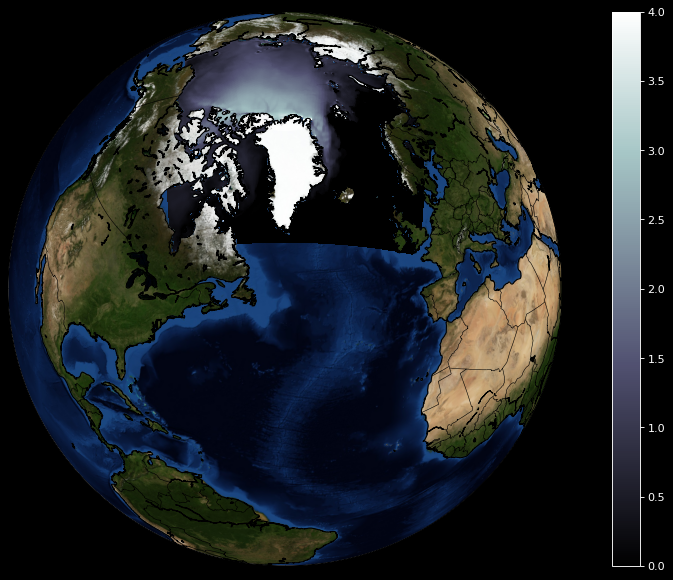

In [108]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 9), dpi=80, facecolor='k')


# Create a Basemap instance with an orthographic projection centered on the Arctic
m = Basemap(projection='nsper', lat_0=50, lon_0=-45, resolution='l')
# k_0=5

# Set the map boundaries to cover the area between 70N to 90N
# m.llcrnrlat = 70
# m.urcrnrlat = 90
# m.llcrnrlon = -180
# m.urcrnrlon = 180
# m.width=10000
# m.height = 20000

# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()

m.bluemarble(scale=1)


mlons, mlats = m(sitm.sit.longitude.to_numpy(), sitm.sit.latitude.to_numpy())
cm1 = m.pcolormesh(mlons, mlats, sitm.sit.isel(time=0).to_numpy(), vmin=0, vmax=4, cmap=cmap)

cbar = plt.colorbar(cm1)  # , fontsize=18)

# Show the plot
plt.show()


/tmp/ipykernel_67500/2129750284.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm1 = m.pcolormesh(mlons, mlats, sitm.sit.isel(time=0).to_numpy(), vmin=0, vmax=4, cmap=cmap)


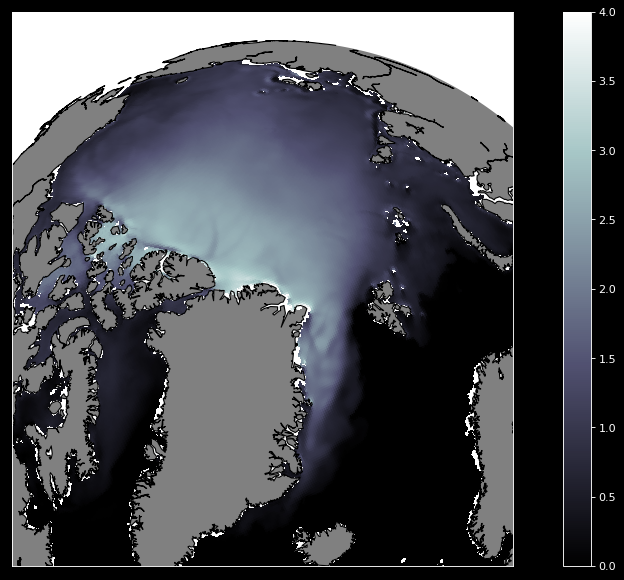

In [154]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 9), dpi=80, facecolor='k')

cmap = plt.get_cmap('bone')

# Create a Basemap instance with an orthographic projection centered on the Arctic
# m = Basemap(projection='nsper', lat_0=80, lon_0=-45, resolution='l',satellite_height=3000000)
# k_0=5

m = Basemap(resolution='l', 
              satellite_height=3000000.,
              projection='nsper', 
              lat_0 = 75., lon_0 = -27.,
              llcrnrx=-2000000.,llcrnry=-1200000.,urcrnrx=1800000.,urcrnry=3000000.
             )

# Set the map boundaries to cover the area between 70N to 90N
m.llcrnrlat = 70
m.urcrnrlat = 90
m.llcrnrlon = -180
m.urcrnrlon = 180
# m.width=10000
# m.height = 20000

# Draw coastlines and countries
m.drawcoastlines()
# m.drawcountries()
m.fillcontinents(color='grey')


# m.bluemarble(scale=.4)


mlons, mlats = m(sitm.sit.longitude.to_numpy(), sitm.sit.latitude.to_numpy())
cm1 = m.pcolormesh(mlons, mlats, sitm.sit.isel(time=0).to_numpy(), vmin=0, vmax=4, cmap=cmap)

cbar = plt.colorbar(cm1)

# Show the plot
plt.show()


In [182]:
from src.utils import modif_plot

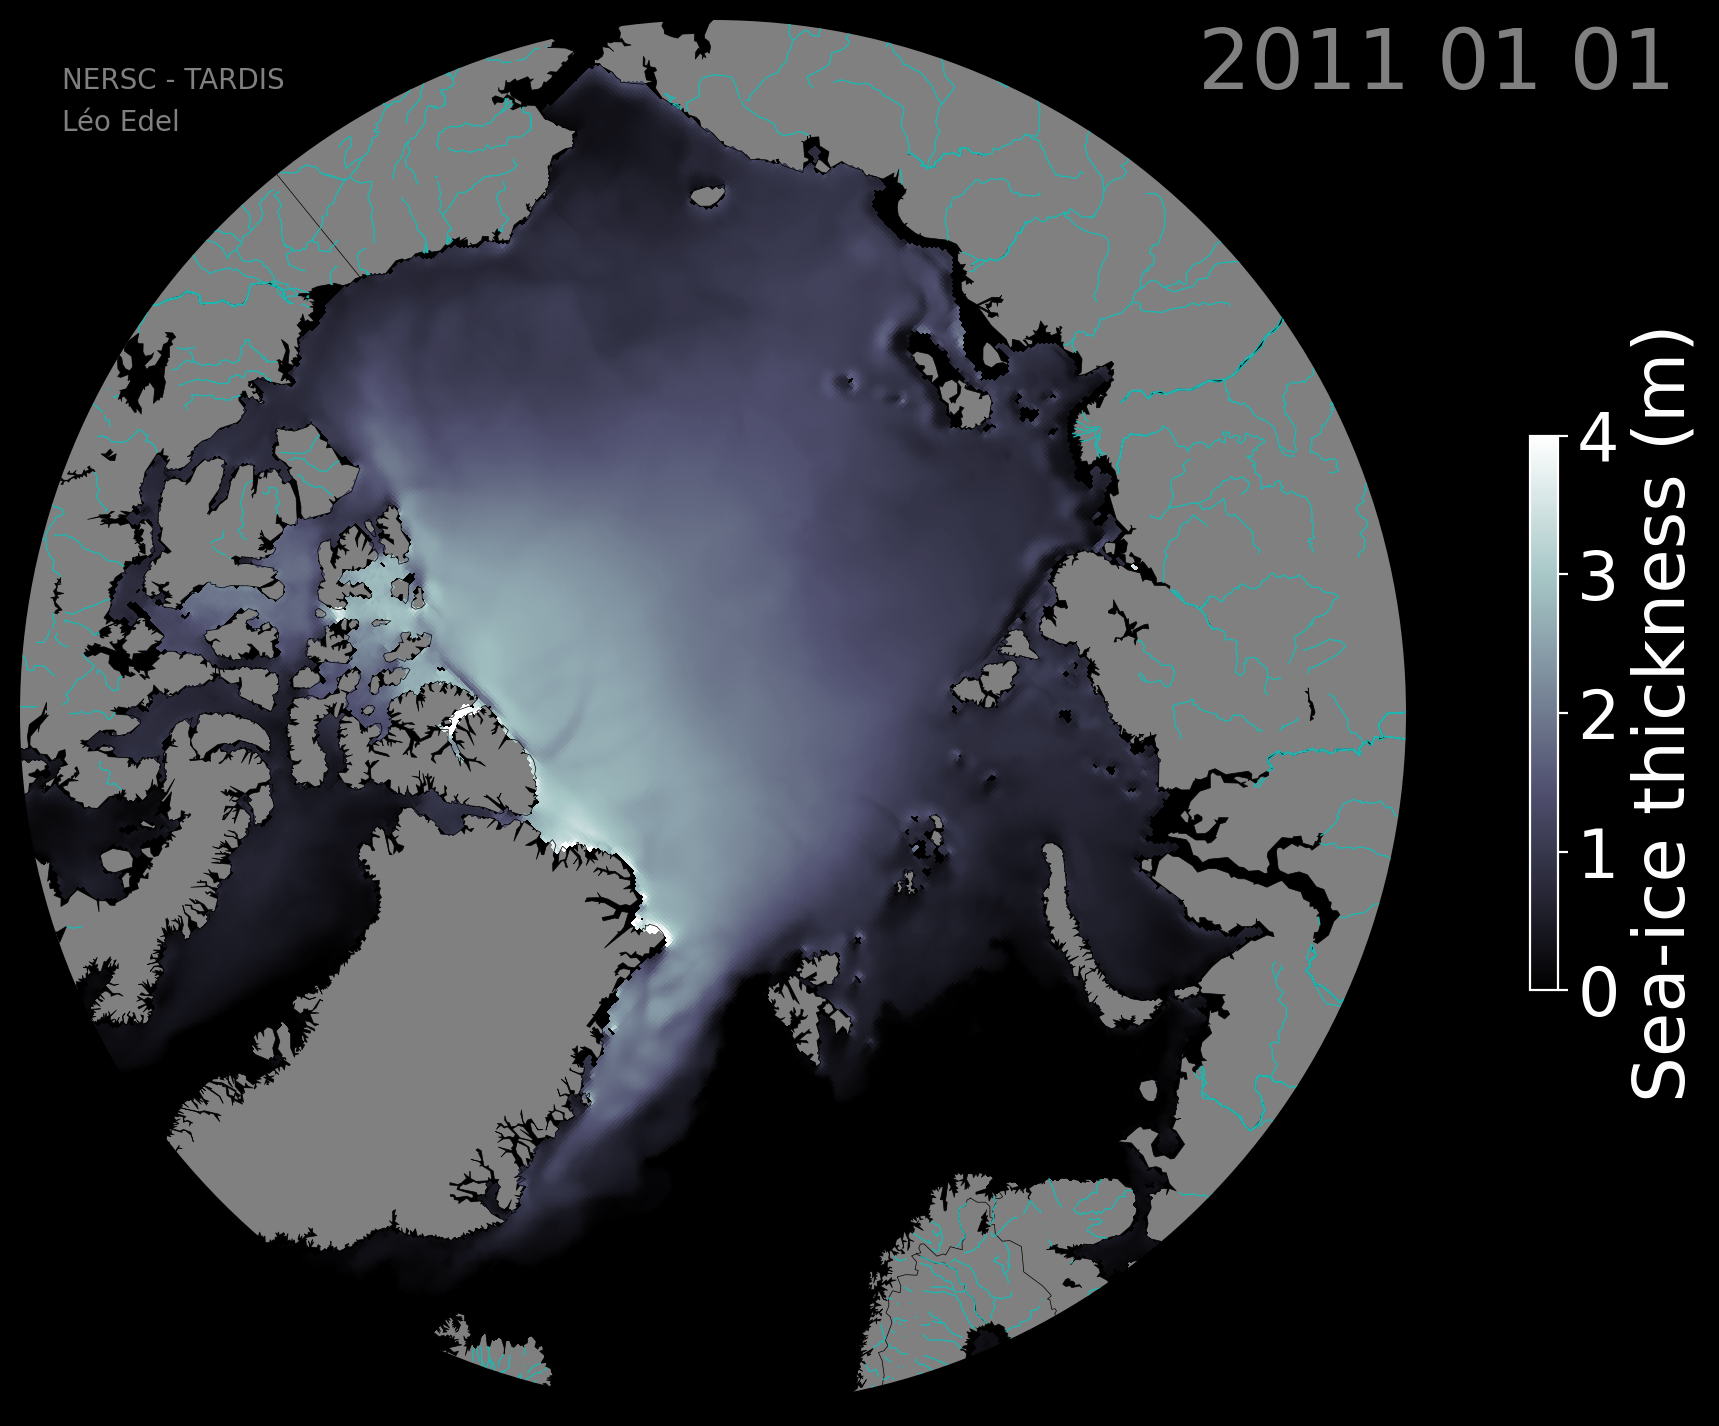

In [215]:
t_idx = 0


fig = plt.figure(figsize=(16, 9), dpi=200, facecolor='k')

cmap = plt.get_cmap('bone')

m = Basemap(projection='npstere', boundinglat=65, lon_0=0, resolution='l', round=True)

# m.bluemarble(scale=.4)


# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

# m.fillcontinents(color='coral',lake_color='aqua')
# draw the edge of the m2 projection region (the projection limb)
# draw lat/lon grid lines every 30 degrees.
# m2.drawmeridians(np.arange(0,360,30), color='w')
# m2.drawparallels(np.arange(-90,90,30), color='w')

m.fillcontinents(color='grey', lake_color='k')
m.drawrivers(color='#1EB8B3')  # 26E2DB
# m.shadedrelief()

m.drawmapboundary(fill_color='k')

# m2.scatter(lat, lon, sit, latlon=True)
mlons, mlats = m(sitm.sit.longitude.to_numpy(), sitm.sit.latitude.to_numpy())
cm1 = m.pcolormesh(mlons, mlats, sitm.sit.isel(time=t_idx).to_numpy(), vmin=0, vmax=4, cmap=cmap)

cbar = plt.colorbar(cm1, label='Sea-ice thickness (m)', shrink=0.4)
cbar.set_ticks([0,1,2,3,4])

# Annotate


plt.annotate('NERSC - TARDIS', xy=(.03,.95), xycoords='axes fraction', color='grey')
plt.annotate('Léo Edel', xy=(.03,.92), xycoords='axes fraction', color='grey')

plt.annotate(f'{sitm.chrono.iloc[t_idx].date.strftime("%Y %m %d")}', xy=(.85,.95), xycoords='axes fraction', color='grey', fontsize=30)



modif_plot.resize(fig, s=24)


plt.show()